# 实验报告二——CIFAR10图⽚识别

## 一、实验目的
学会构建CNN网络

## 二、实验环境
- 语言环境：python3.12
- 编译器：jupyterlab
- 深度学习环境：Pytorch

## 三、实验内容与方法

### 1.卷积
卷积（Convolution）是卷积神经⽹络（CNN）中最核⼼的数学运算，它通过局部感受野和权值共享机制有效提取输
⼊数据的空间特征。卷积操作的主要作⽤：
1. 局部连接性：
每个卷积核只与输⼊数据的局部区域相连，这与全连接⽹络形成鲜明对⽐
这种特性显著减少了⽹络参数数量，提⾼了计算效率
2. 权值共享：
同⼀个卷积核在输⼊数据的不同位置使⽤相同的权重参数
这使得⽹络能够检测输⼊数据中的平移不变特征
3. 特征提取机制：
低层卷积核通常学习边缘、颜⾊等基础特征
⾼层卷积核逐渐组合出更复杂的语义特征
通过多层卷积实现特征的层次化表⽰

### 2.池化
池化层（Pooling Layer）是卷积神经⽹络（CNN）中的⼀种重要层类型，它在降维、减少参数量、控制过拟合等⽅⾯
起到关键作⽤。池化层的主要作⽤包括：
1. 降维和减少计算量： 池化层通过对输⼊特征图进⾏下采样（Subsampling）操作，减少了特征图的尺⼨，从⽽降
低了后续层的计算量和内存消耗。
2. 特征平移不变性： 池化层能够使⽹络对输⼊图像的⼩幅度平移、旋转或缩放具有更强的鲁棒性。例如，最⼤池化
（Max Pooling）通过选择池化窗⼝中的最⼤值，保留了最显著的特征，从⽽提⾼了特征的平移不变性。
3. 减少过拟合： 通过减少特征图的维度和参数量，池化层可以降低模型的复杂度，有助于防⽌模型对训练数据的过
拟合，提⾼模型在测试数据上的泛化能⼒。
4. 突出显著特征： 最⼤池化（Max Pooling）和平均池化（Average Pooling）是两种常⻅的池化操作。最⼤池化
可以保留最显著的特征，忽略不重要的信息；平均池化则通过取平均值的⽅式保留整体特征。
池化层的常⻅类型和操作包括：
最⼤池化（Max Pooling）：在池化窗⼝内选择最⼤值，常⽤于提取最显著特征，⽐如提取图⽚纹理。
平均池化（Average Pooling）：在池化窗⼝内取平均值，常⽤于保留整体特征，⽐如提取图⽚背景。
全局平均池化（Global Average Pooling）：对整个特征图进⾏平均池化，常⽤于减少全连接层的输⼊维度。

### 3.损失函数和优化器
- **指定优化器：** 优化器决定了模型的学习⽅式和速度。通过选择合适的优化器（如SGD、Adam、RMSprop等），我们可以控制模型参数的更新规则和训练效率。优化器的选择对模型的训练效果有很⼤影响。
- **定义损失函数：** 损失函数（或⽬标函数）衡量了模型预测值与真实值之间的差距。编译模型时，我们需要指定⼀个合适的损失函数（如均⽅误差、交叉熵损失等），以指导模型的参数调整⽅向，使其逐步逼近最优解。
- **设置评价指标：** 评价指标⽤于评估模型在训练和测试过程中的性能。编译模型时，可以定义⼀个或多个评价指标（如准确率、精确率、召回率等），这些指标将⽤于在训练过程中监控模型的表现。

## 四、实验过程和步骤

### 0.导入必要的库

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

### 1.准备数据集
CIFAR10数据集共有60000个样本，每个样本都是一张32*32像素的RGB图像（彩色图像），每个RGB图像又必定分为3个通道（R通道、G通道、B通道）。这60000个样本被分成了50000个训练样本和10000个测试样本。
CIFAR10数据集是用来监督学习训练的，那么每个样本就一定都配备了一个标签值（用来区分这个样本是什么），不同类别的物体用不同的标签值，CIFAR10中有10类物体，标签值分别按照0~9来区分,他们分别是飞机（ airplane ）、汽车（ automobile ）、鸟（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、青蛙（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。

In [2]:
def load_cifar10(data_dir):
    import pickle
    train_data, train_labels = [], []
    for i in range(1, 6):
        file_path = os.path.join(data_dir, f"data_batch_{i}")
        with open(file_path, 'rb') as f:
            batch = pickle.load(f, encoding='latin1')
            train_data.extend(batch['data'])
            train_labels.extend(batch['labels'])

    test_file = os.path.join(data_dir, "test_batch")
    with open(test_file, 'rb') as f:
        test_batch = pickle.load(f, encoding='latin1')
        test_data = test_batch['data']
        test_labels = test_batch['labels']

    return (train_data, train_labels), (test_data, test_labels)

### 2.数据预处理

In [3]:
def load_data():
    (train_data, train_labels), (test_data, test_labels) = load_cifar10('./cifar-10-batches-py')
    # 转换为 NumPy 数组并归一化
    train_imgs = np.array(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # (N, H, W, C)
    test_imgs = np.array(test_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # (N, H, W, C)
    train_imgs, test_imgs = train_imgs/255.0, test_imgs/255.0  # 归一化

    # 从训练集划分 20% 作为验证集 (stratified split)
    train_imgs, val_imgs, train_labels, val_labels = train_test_split(
        train_imgs, train_labels,
        test_size=0.2,
        random_state=42,  # 固定随机种子确保可复现
        stratify=train_labels  # 保持类别比例一致
    )
    return (train_imgs, train_labels), (val_imgs, val_labels), (test_imgs, test_labels)

# 准备数据
(train_imgs, train_labels),(val_imgs, val_labels),(test_imgs, test_labels) = load_data()

### 3.图片可视化

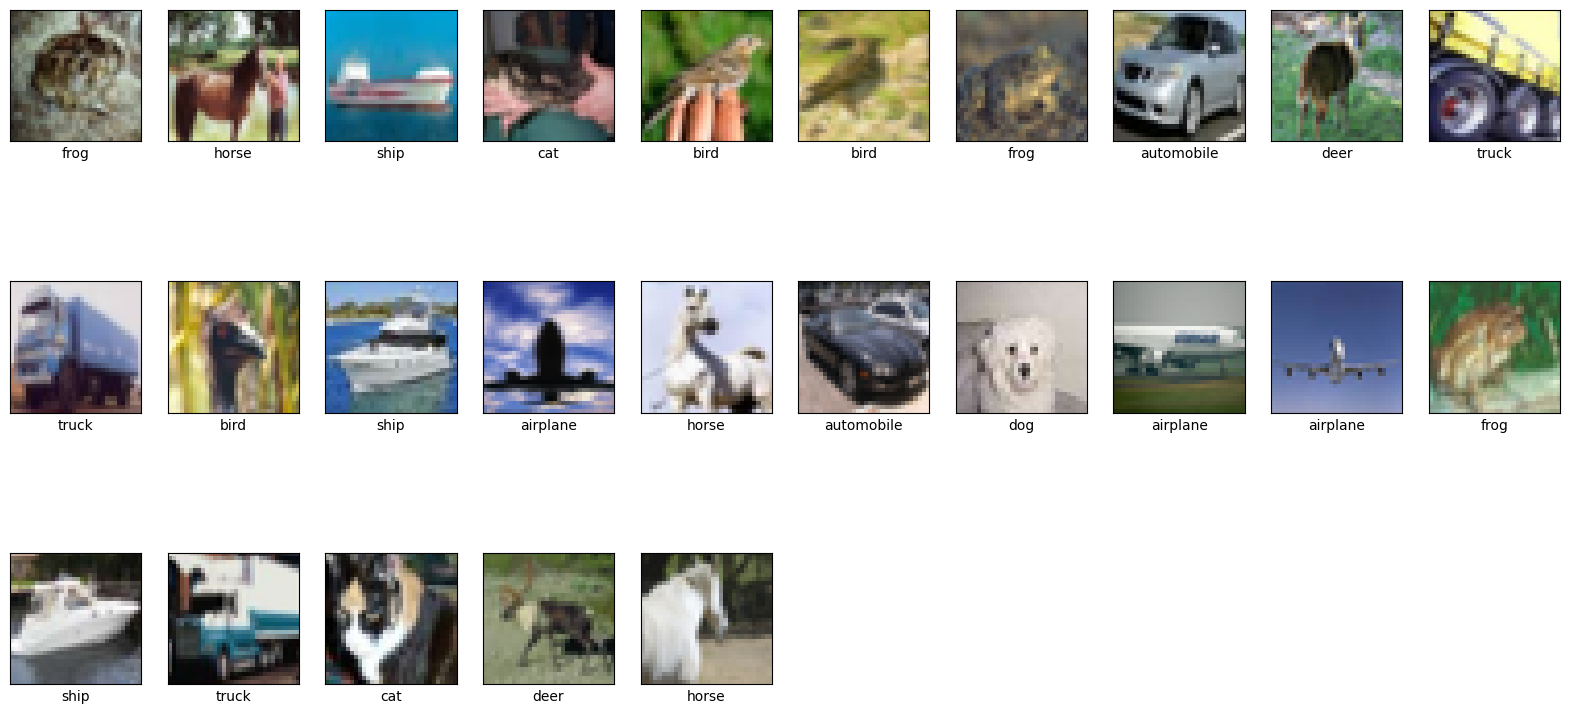

In [4]:
def plot_datasets(images, labels, num: int):
    """
    画出train数据集上前num个图片
    :param num:
    :return:
    """
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
                   'horse','ship', 'truck']
    plt.figure(figsize=(20, 10))
    for i in range(num):
        # 将整个figure分成(num/10 + 1) 行，10列
        plt.subplot(int(num / 10 + 1), 10, i + 1)
        # 设置不显示x轴刻度
        plt.xticks([])
        # 设置不显示y轴刻度
        plt.yticks([])
        # 设置不显示子图网格线
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

plot_datasets(train_imgs, train_labels, 25)

### 4.模型构建

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)  # [3,32,32] => [32,30,30]
        self.pool1 = nn.MaxPool2d(2, 2)  # [32,30,30] => [32,15,15]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # [32,15,15] => [64,13,13]
        self.pool2 = nn.MaxPool2d(2, 2)  # [64,13,13] => [64,6,6]
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)  # [64,6,6] => [64,4,4]

        self.flatten = nn.Flatten()  # [64,4,4] => 1024
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  # 1024 => 64
        self.fc2 = nn.Linear(64, 10)  # 64 => 10

    def forward(self, x):
        """
        调用我们定义好的模块，如conv1、fc1对输入的tensor x进行处理
        """
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 创建模型实例
model = CNN()
# 打印模型结构
print(model)
# 示例输入
input_tensor = torch.randn(1, 3, 32, 32) # batch_size=1, channels=3, height=32,
width=32
output = model(input_tensor)
print(output.shape) 

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
torch.Size([1, 10])


### 5.模型训练

In [6]:
# 评估函数
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            # images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return loss, accuracy

# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 验证阶段
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch + 1}/{epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs


### 5.结果分析

In [ ]:
(train_imgs, train_labels),(val_imgs, val_labels),(test_imgs, test_labels) = load_data()

# 转换为PyTorch张量并调整维度顺序 (N, H, W, C) -> (N, C, H, W)
train_imgs = torch.FloatTensor(train_imgs).permute(0, 3, 1, 2)
val_imgs = torch.FloatTensor(val_imgs).permute(0, 3, 1, 2)
test_imgs = torch.FloatTensor(test_imgs).permute(0, 3, 1, 2)

train_labels = torch.LongTensor(train_labels)
val_labels = torch.LongTensor(val_labels)
test_labels = torch.LongTensor(test_labels)

# 创建数据集和数据加载器
batch_size = 64
train_dataset = TensorDataset(train_imgs, train_labels)
val_dataset = TensorDataset(val_imgs, val_labels)
test_dataset = TensorDataset(test_imgs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 初始化模型
model = CNN()
print(model)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# 训练模型
epochs = 20
train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )

# 绘制训练曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# 测试最佳模型
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f'Test Accuracy: {test_acc:.2f}%')

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
